In [72]:
from Data_manager.UserUtils import *
from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
import numpy as np
np.random.seed(565)
URM_all = getURM_all()
URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
#URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.80)

100%|█████████▉| 22216/22222 [07:01<00:00, 52.67it/s] 


In [73]:
# SETUP EVALUATORS
from Evaluation.Evaluator import EvaluatorHoldout

#evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2125 (16.8%) Users that have less than 1 test interactions


In [74]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URM_train_validation).indptr)
profile_length, profile_length.shape

(array([35, 28,  3, ...,  7, 18, 57], dtype=int32), (12638,))

In [75]:
block_size = int(len(profile_length)*0.1)
block_size

1263

In [16]:
sorted_users = np.argsort(profile_length)
for group_id in range(0, 10):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 1263, average p.len 0.85, median 1.0, min 0, max 2
Group 1, #users in group 1263, average p.len 2.43, median 2.0, min 2, max 3
Group 2, #users in group 1263, average p.len 4.73, median 5.0, min 3, max 6
Group 3, #users in group 1263, average p.len 7.66, median 8.0, min 6, max 10
Group 4, #users in group 1263, average p.len 11.82, median 12.0, min 10, max 14
Group 5, #users in group 1263, average p.len 17.55, median 17.0, min 14, max 21
Group 6, #users in group 1263, average p.len 25.77, median 26.0, min 21, max 31
Group 7, #users in group 1263, average p.len 37.68, median 37.0, min 31, max 46
Group 8, #users in group 1263, average p.len 58.74, median 57.0, min 46, max 76
Group 9, #users in group 1263, average p.len 131.98, median 109.0, min 76, max 499


In [76]:
from Hybrid import *
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.FactorizationMachines.LightFMRecommender import LightFMCFRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import *
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   #"NMF": NMFRecommender,
                                   #"MF_BPR": MatrixFactorization_BPR_Cython,
                                   "SLIM_ELASTIC": MultiThreadSLIM_SLIMElasticNetRecommender,
                                   #"SLIM_BPR": SLIM_BPR_Cython,
                                   #"LightFM": LightFMCFRecommender,
                                   #"IALS": IALSRecommender,
                                   #"EASE_R": EASE_R_Recommender,
                                   #"HYBRID": HybridRecommender
                                   }
collaborative_recommender_class.items()

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train_validation)
    recommender_object_dict[label] = recommender_object
    
    
recommender_object_dict["TopPop"].fit()
recommender_object_dict["SLIM_ELASTIC"].fit(topK=8894, l1_ratio=0.05565733019999427, alpha=0.0012979360257937668, workers=7)
recommender_object_dict["PureSVD"].fit(num_factors=70, random_seed=42)
#recommender_object_dict["NMF"].load_model("result_experiments/", "NMFRecommender_best_model.zip")
recommender_object_dict["P3alpha"].fit(topK=76, alpha=0.377201600381895, normalize_similarity=True)
recommender_object_dict["RP3beta"].fit(topK=101, alpha=0.3026342852596128, beta=0.058468783118329024)
recommender_object_dict["UserKNNCF"].fit(topK=469, shrink=38, similarity='asymmetric', normalize=True,
                                       feature_weighting='TF-IDF', asymmetric_alpha=0.40077406933762383)
recommender_object_dict["ItemKNNCF"].fit(topK=31, shrink=435, similarity='tversky', normalize=True,
                                       feature_weighting='BM25', tversky_alpha=0.17113169506422393, tversky_beta=0.5684024974085575)
#recommender_object_dict["EASE_R"].fit(topK=24, l2_norm=37.54323189430143)

#recommender_object_dict["MF_BPR"].fit(sgd_mode="adagrad", num_factors=219, batch_size=32, learning_rate=0.08036400470449359,positive_reg=0.016211221706684466,negative_reg=0.00012672106970228173, epochs=260, random_seed=1234)
#recommender_object_dict["SLIM_BPR"].fit(topK=46, symmetric=True, sgd_mode="adagrad", epochs=195, lambda_i=0.00035732097169170193, lambda_j=0.004542391418975173, learning_rate=0.0002291767622519941)
#recommender_object_dict["LightFM"].load_model("result_experiments/", "LightFMCFRecommender_best_model.zip")
#recommender_object_dict["IALS"].fit()
#recommender_object_dict["HYBRID"].fit()
from Hybrid import LinearHybridRecommender
#recommenders = [SLIM_Elastic, RP3Beta, ItemKNNCF, UserKNNCF] # ORDER MATTER!!!!!!!!!

#alphas = [0.6321191861151624, 1.390285841050952, 0.23173069155212617, 0.0031112219228564527]

#recommender_object_dict["HYBRID"] = LinearHybridRecommender(URM_train, recommenders)
#recommender_object_dict["HYBRID"].fit(alphas)

TopPopRecommender: URM Detected 222 ( 1.8%) users with no interactions.
TopPopRecommender: URM Detected 112 ( 0.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 222 ( 1.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 112 ( 0.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 222 ( 1.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 112 ( 0.5%) items with no interactions.
P3alphaRecommender: URM Detected 222 ( 1.8%) users with no interactions.
P3alphaRecommender: URM Detected 112 ( 0.5%) items with no interactions.
RP3betaRecommender: URM Detected 222 ( 1.8%) users with no interactions.
RP3betaRecommender: URM Detected 112 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 222 ( 1.8%) users with no interactions.
PureSVDRecommender: URM Detected 112 ( 0.5%) items with no interactions.
SLIMElasticNetRecommender: URM Detected 222 ( 1.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detecte


100%|█████████▉| 22192/22222 [01:46<00:00, 121.44it/s]

PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 1.02 sec
P3alphaRecommender: Similarity column 22222 (100.0%), 5486.61 column/sec. Elapsed time 4.05 sec
RP3betaRecommender: Similarity column 22222 (100.0%), 4415.80 column/sec. Elapsed time 5.03 sec
Similarity column 12638 (100.0%), 9301.97 column/sec. Elapsed time 1.36 sec
Similarity column 22222 (100.0%), 8681.40 column/sec. Elapsed time 2.56 sec


In [18]:
# EQUAL SIZE GROUPING
from Evaluation.Evaluator import EvaluatorHoldout

MAP_recommender_per_group = {}
cutoff = 10

for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
        

Group 0, #users in group 1263, average p.len 0.85, median 1.0, min 0, max 2
EvaluatorHoldout: Ignoring 2163 (17.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 11375 Users
EvaluatorHoldout: Processed 481 (100.0%) in 0.54 sec. Users per second: 885
EvaluatorHoldout: Processed 481 (100.0%) in 0.65 sec. Users per second: 739
EvaluatorHoldout: Processed 481 (100.0%) in 0.50 sec. Users per second: 963
EvaluatorHoldout: Processed 481 (100.0%) in 0.46 sec. Users per second: 1051
EvaluatorHoldout: Processed 481 (100.0%) in 0.45 sec. Users per second: 1062
EvaluatorHoldout: Processed 481 (100.0%) in 0.52 sec. Users per second: 921
EvaluatorHoldout: Processed 481 (100.0%) in 0.46 sec. Users per second: 1036
Group 1, #users in group 1263, average p.len 2.43, median 2.0, min 2, max 3
EvaluatorHoldout: Ignoring 2163 (17.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 11375 Users
EvaluatorHoldout: Processed 580 (100.0%) in 0.54 sec. Users per

In [77]:
# PROFILE LENGTH BASED GROUPING
from Evaluation.Evaluator import EvaluatorHoldout
import numpy as np

MAP_recommender_per_group = {}
cutoff = 10

# Define the cutoffs for profile length for each group
profile_length_cutoffs = [2, 4, 6, 8, 25, 40, 65, 130, 200, 1500]

for group_id in range(len(profile_length_cutoffs)):

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if group_id == 0:
        users_in_group_flag = profile_length < profile_length_cutoffs[group_id]
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[group_id - 1], profile_length < profile_length_cutoffs[group_id])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]

    if len(users_in_group) > 0:
        users_in_group_p_len = profile_length[users_in_group]

        print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
            group_id,
            users_in_group.shape[0],
            users_in_group_p_len.mean(),
            np.median(users_in_group_p_len),
            users_in_group_p_len.min(),
            users_in_group_p_len.max()))

        # Select users not in the current group
        users_not_in_group_flag = np.isin(np.arange(len(profile_length)), users_in_group, invert=True)
        users_not_in_group = np.arange(len(profile_length))[users_not_in_group_flag]

        evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

        for label, recommender in recommender_object_dict.items():
            result_df, _ = evaluator_test.evaluateRecommender(recommender)
            if label in MAP_recommender_per_group:
                MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
            else:
                MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
    else:
        print(f"Group {group_id} has no users.")

Group 0, #users in group 1275, average p.len 0.83, median 1.0, min 0, max 1
EvaluatorHoldout: Ignoring 2125 (16.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 11363 Users
EvaluatorHoldout: Processed 509 (100.0%) in 0.56 sec. Users per second: 911
EvaluatorHoldout: Processed 509 (100.0%) in 0.59 sec. Users per second: 857
EvaluatorHoldout: Processed 509 (100.0%) in 0.58 sec. Users per second: 883
EvaluatorHoldout: Processed 509 (100.0%) in 0.49 sec. Users per second: 1031
EvaluatorHoldout: Processed 509 (100.0%) in 0.51 sec. Users per second: 1005
EvaluatorHoldout: Processed 509 (100.0%) in 0.71 sec. Users per second: 713
EvaluatorHoldout: Processed 509 (100.0%) in 0.54 sec. Users per second: 941
Group 1, #users in group 1302, average p.len 2.45, median 2.0, min 2, max 3
EvaluatorHoldout: Ignoring 2125 (16.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 11336 Users
EvaluatorHoldout: Processed 623 (100.0%) in 0.54 sec. Users per 

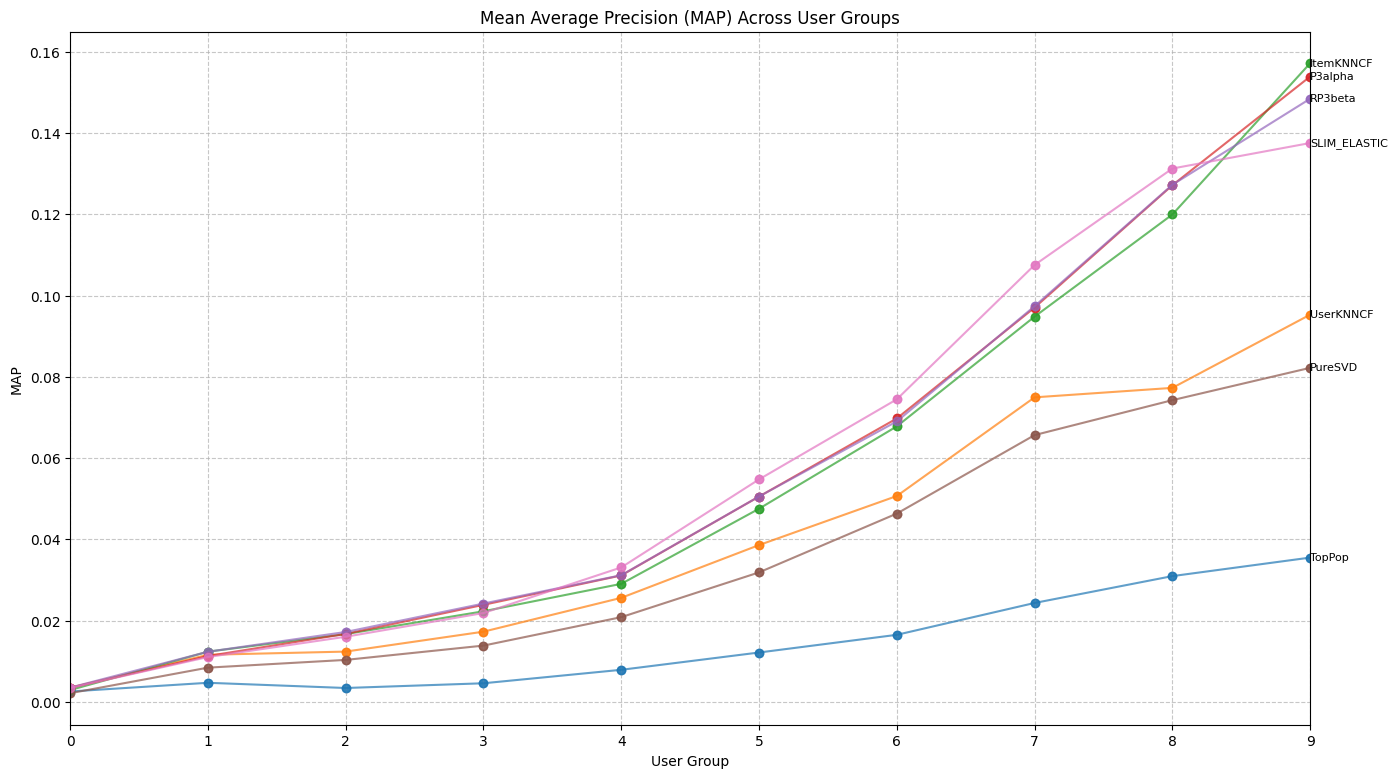

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have the following data structure
# recommender_object_dict = {'Recommender1': recommender1, 'Recommender2': recommender2, ...}
# MAP_recommender_per_group = {'Recommender1': [0.8, 0.7, 0.6, ...], 'Recommender2': [0.9, 0.8, 0.7, ...], ...}

# Your original code
_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label, alpha=0.7)

# Modifications for a better plot
plt.title('Mean Average Precision (MAP) Across User Groups')
plt.xlabel('User Group')
plt.ylabel('MAP')

# Use a line plot for better trend visualization
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.plot(np.arange(0, len(results)), results, marker='o', linestyle='-', alpha=0.7)
    
    # Annotate the lines with the names of the recommender systems
    last_value = results[-1]
    plt.text(len(results)-1, last_value, label, ha='left', va='center', fontsize=8)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis ticks to integers from 0 to 4
plt.xticks(np.arange(0, 10))

# Set x-axis limits to 0 and 4
plt.xlim(0, 9)

plt.show()

In [79]:
import pandas as pd
print(pd.DataFrame(MAP_recommender_per_group))

     TopPop  UserKNNCF  ItemKNNCF   P3alpha   RP3beta   PureSVD  SLIM_ELASTIC
0  0.002560   0.003509   0.002912  0.003455  0.003514  0.002135      0.003432
1  0.004702   0.011595   0.012361  0.011294  0.012343  0.008430      0.011044
2  0.003421   0.012379   0.016689  0.016730  0.017206  0.010333      0.016034
3  0.004585   0.017281   0.022299  0.023886  0.024200  0.013853      0.021871
4  0.007898   0.025608   0.029051  0.031115  0.031181  0.020854      0.033092
5  0.012154   0.038593   0.047536  0.050526  0.050541  0.031868      0.054753
6  0.016507   0.050663   0.067806  0.069747  0.069024  0.046340      0.074459
7  0.024346   0.074942   0.094805  0.097036  0.097377  0.065653      0.107513
8  0.030953   0.077269   0.119935  0.127135  0.127250  0.074248      0.131247
9  0.035510   0.095290   0.157158  0.153886  0.148422  0.082206      0.137525


In [80]:
#                         0, 1, 2, 3, 4,  5,  6,   7,   8,    9
#profile_length_cutoffs = [2, 4, 6, 8, 25, 50, 80, 100, 250, 1500]
df = pd.DataFrame(MAP_recommender_per_group)

for index, row in df.iterrows():
    sorted_row = row.sort_values(ascending=False)
    max_value = sorted_row.iloc[0]
    max_index = sorted_row.index[0]
    second_max_value = sorted_row.iloc[1]
    second_max_index = sorted_row.index[1]

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if index == 0:
        users_in_group_flag = np.logical_and(profile_length > 0, profile_length < profile_length_cutoffs[index])
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[index - 1], profile_length < profile_length_cutoffs[index])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]

    # Calculate the minimum and maximum profile lengths for the users in the group
    min_profile_length = profile_length[users_in_group_flag].min()
    max_profile_length = profile_length[users_in_group_flag].max()

    # Calculate the number of users in the group
    num_users_in_group = len(users_in_group)

    print(f"Row {index}: Max value is {max_value} at {max_index}, Second max value is {second_max_value} at {second_max_index}, Min profile length is {min_profile_length}, Max profile length is {max_profile_length}, Number of users in group is {num_users_in_group}, diff with slim is {max_value - df['SLIM_ELASTIC'][index]}")

Row 0: Max value is 0.0035139707487448165 at RP3beta, Second max value is 0.0035089811956216677 at UserKNNCF, Min profile length is 1, Max profile length is 1, Number of users in group is 1053, diff with slim is 8.162597062400662e-05
Row 1: Max value is 0.0123608881754949 at ItemKNNCF, Second max value is 0.012343499197431764 at RP3beta, Min profile length is 2, Max profile length is 3, Number of users in group is 1302, diff with slim is 0.0013172310122550861
Row 2: Max value is 0.017205951210375985 at RP3beta, Second max value is 0.016729526618907146 at P3alpha, Min profile length is 4, Max profile length is 5, Number of users in group is 1000, diff with slim is 0.0011723322564030705
Row 3: Max value is 0.024199839767663094 at RP3beta, Second max value is 0.02388582194181561 at P3alpha, Min profile length is 6, Max profile length is 7, Number of users in group is 817, diff with slim is 0.0023291898252466095
Row 4: Max value is 0.03309153423958121 at SLIM_ELASTIC, Second max value is 0